# Onset function and Novelty function
## Novelty Function
---

### References
Text book: [Sect. 9.3.1](https://ieeexplore.ieee.org/document/9966202/) 

Slides: [09-03-ACA-Temporal-Onsets.pdf](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/09-03-ACA-Temporal-Onsets.pdf)

#### Summary:
A Novelty Function measures the probability of new events or signal changes occurring over `time`. Also known as a detection function or difference function, it can be categorized into three domains: `time domain`, `pitch domain`, and `STFT-based`.


#### How it usually works:
(For a detailed implementation of these steps, we can examine the [`computeNoveltyFunction`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/computeNoveltyFunction.py#L32) source code)
1. Feature extraction
2. Deveriation computation
3. Result Smoothing
4. Half-Wave-Rectification
Finally, we can attempt to find local maxima above the threshold for tasks such as onset, beat detection.





### 1. Time Domain Novelty Function:


In [5]:
# an example of time domain novelty function:
import numpy as np
import math
from scipy.signal import filtfilt
from scipy.signal import find_peaks

def computeEnergyNovelty(wav, frame_size, hop_size, f_s):
    # Calculate the number of frames
    num_frames = 1 + (len(wav) - frame_size) // hop_size
    energy = np.zeros(num_frames)
    t = np.arange(0, len(wav) / f_s, hop_size / f_s)[:num_frames]
    # Compute energy for each frame
    for i in range(num_frames):
        start = i * hop_size
        frame = wav[start:start+frame_size]
        energy[i] = np.sum(frame ** 2)
    
    # Compute novelty function as the positive difference between adjacent energy values
    d = np.diff(energy, prepend=energy[0])
    
    fLenSmoothLpInS = 0.07
    fLenThreshLpInS = 0.14
    iLenSmoothLp = np.max([2, math.ceil(fLenSmoothLpInS * f_s / hop_size)])
    iLenThreshLp = np.max([2, math.ceil(fLenThreshLpInS * f_s / hop_size)])

    b = np.ones(iLenSmoothLp) / iLenSmoothLp
    d = filtfilt(b, 1, d)
    d[d < 0] = 0

    # compute threshold
    iLenThreshLp = min(iLenThreshLp, np.floor(len(d)/3))
    b = np.ones(iLenThreshLp) / iLenThreshLp
    G_T = .4 * np.mean(d[np.arange(1, d.shape[0])]) + filtfilt(b, 1, d)

    # find local maxima above the threshold
    iPeaks = find_peaks(d - G_T, height=0)

    return d, t, iPeaks[0]

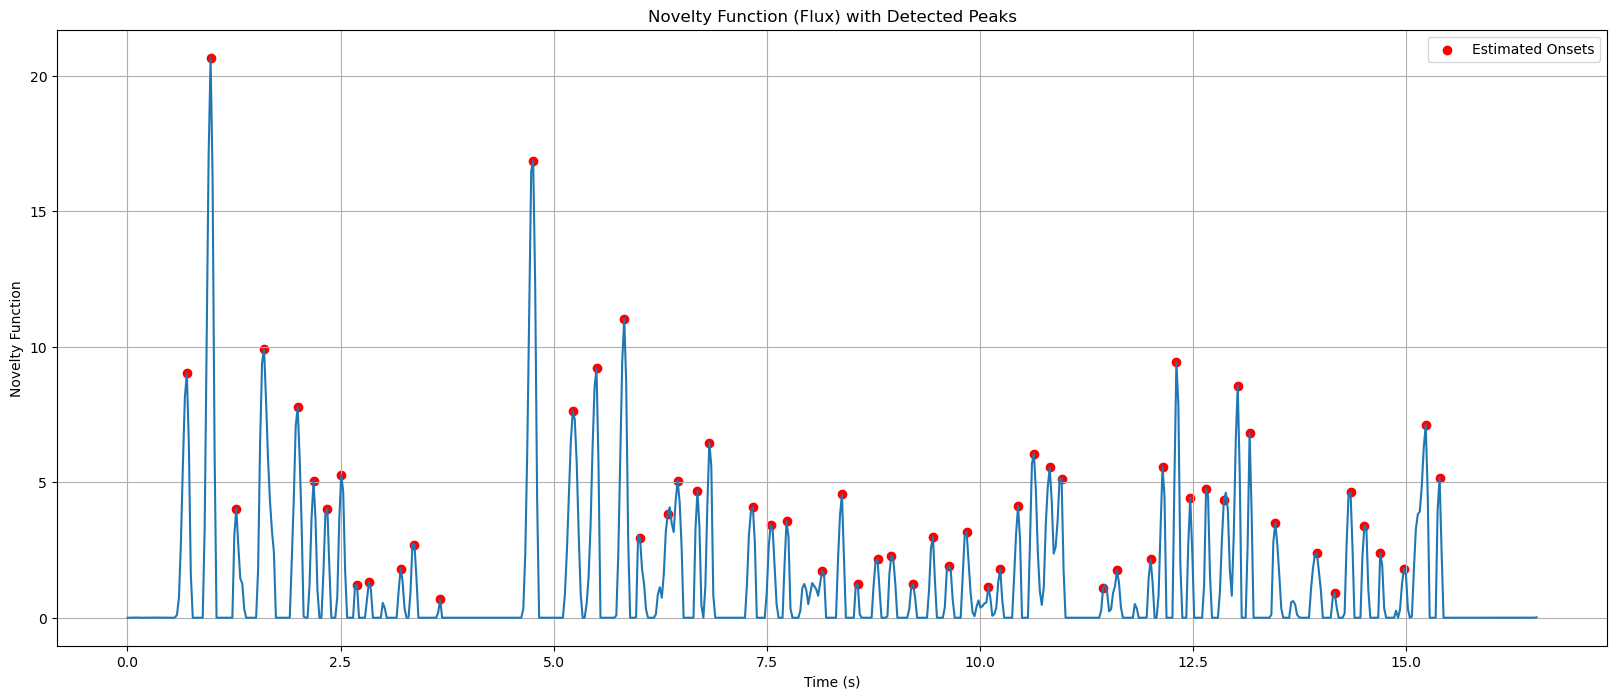

In [7]:
from utils.visualize import visualizeNoveltyFunction
from pyACA import ToolReadAudio

# Read audio
f_s, wav = ToolReadAudio('asset/pitch/63-M2_AMairena.wav')
d, t, iPeaks = computeEnergyNovelty(wav, frame_size=2048, hop_size=1024, f_s=f_s)
visualizeNoveltyFunction(d, t, iPeaks)


### 2. STFT-based Novelty Function:
Here, supported novelty function for `STFT-based` in PyACA are: 
-    [`NoveltyFlux`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyFlux.py)
-    [`NoveltyHainsworth`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyHainsworth.py)
-    [`NoveltyLaroche`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyLaroche.py)

Here is an example:

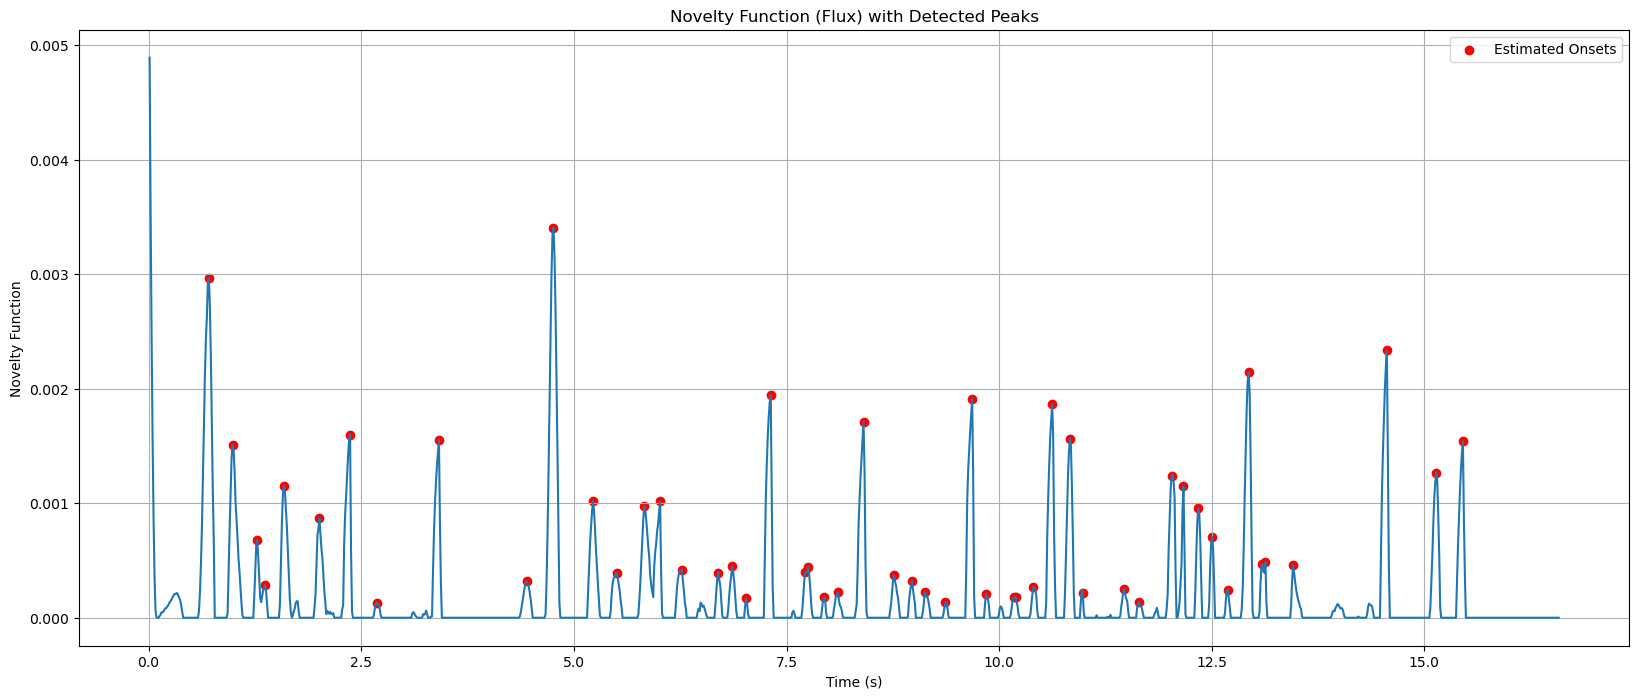

In [8]:
from pyACA import computeNoveltyFunction
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA.ToolComputeHann import ToolComputeHann
from utils.visualize import visualizeNoveltyFunction
from pyACA import ToolReadAudio

# Settings
iBlockLength = 1024
iHopLength = 512
novelty_func = 'Laroche' # can be 'Hainsworth', 'Laroche'
# Read audio
f_s, wav = ToolReadAudio('asset/pitch/63-M2_AMairena.wav')
# Compute Hann window
afWindow = ToolComputeHann(iBlockLength)
# Preprocess audio (normalize & downmix)
x = ToolPreprocAudio(wav)
# Compute novelty function (using Flux algorithm for example)
[d, t, peaks] = computeNoveltyFunction(novelty_func, x, f_s, afWindow, iBlockLength, iHopLength)
# Visualize novelty function
visualizeNoveltyFunction(d, t, peaks)




### 3. Pitch Domain Novelty Function:

Here, we can simply take the pitch estimation function that used in `PitchContour.ipynb` to compute pitch domain novelty function:

In [9]:
# An example of pitch domain novelty function:
import pyACA

def computePitchNovelty(wav, frame_size, hop_size, f_s):
    pitchAlgo = 'TimeAcf'
    est_freq, t = pyACA.computePitch(pitchAlgo, wav, f_s, iBlockLength=frame_size, iHopLength=hop_size)
    d = np.diff(est_freq, prepend=est_freq[0])
    
    fLenSmoothLpInS = 0.1
    fLenThreshLpInS = 0.14
    iLenSmoothLp = np.max([2, math.ceil(fLenSmoothLpInS * f_s / hop_size)])
    iLenThreshLp = np.max([2, math.ceil(fLenThreshLpInS * f_s / hop_size)])

    b = np.ones(iLenSmoothLp) / iLenSmoothLp
    d = filtfilt(b, 1, d)
    d[d < 0] = 0

    # compute threshold
    iLenThreshLp = min(iLenThreshLp, np.floor(len(d)/3))
    b = np.ones(iLenThreshLp) / iLenThreshLp
    G_T = .6 * np.mean(d[np.arange(1, d.shape[0])]) + filtfilt(b, 1, d)

    # find local maxima above the threshold
    iPeaks = find_peaks(d - G_T, height=0)

    return d, t, iPeaks[0]

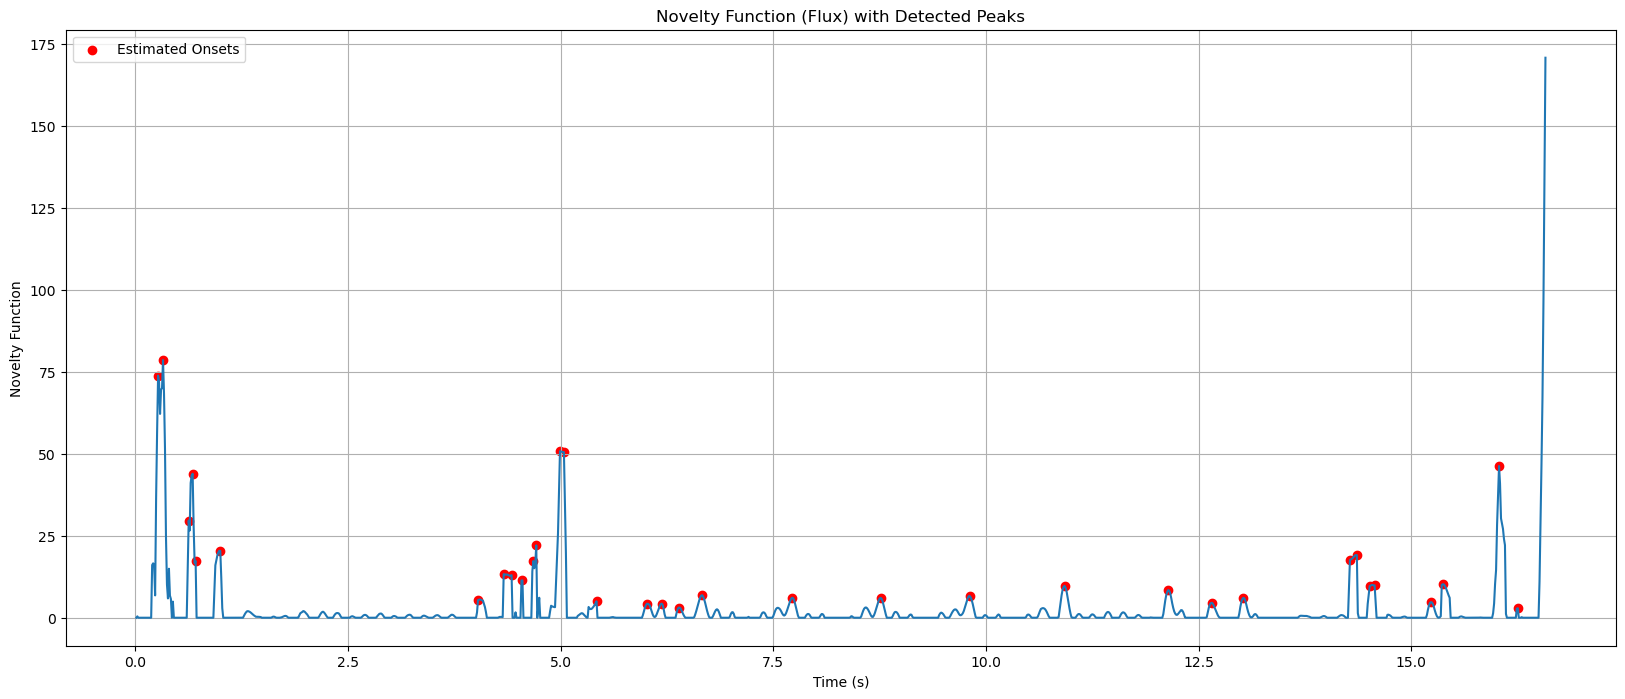

In [10]:

from pyACA import ToolReadAudio

f_s, wav = ToolReadAudio('asset/pitch/63-M2_AMairena.wav')
d, t, iPeaks = computePitchNovelty(wav, 1024, 512, f_s)
visualizeNoveltyFunction(d, t, iPeaks)

# Onset Detection
---
### References
Text book: [Sect. 9.3](https://ieeexplore.ieee.org/document/9966202/) 

Slides: [09-03-ACA-Temporal-Onsets.pdf](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/09-03-ACA-Temporal-Onsets.pdf)

### Summary:
The goal of onset detection is to segment the audio stream into separate musical events. This supports tasks such as tempo detection or automatic music transcription and enables the analysis of rhythm and timing.


### How it usually works:
1. Novelty Function computation
2. Peak picking

That is, we can just simply use novelty function above and pick proper peaks for the onset detection. For exanple, We can generate a rhythmic ticking sound, compute its novelty function, and then pick the peak of its novelty function. See the code below:

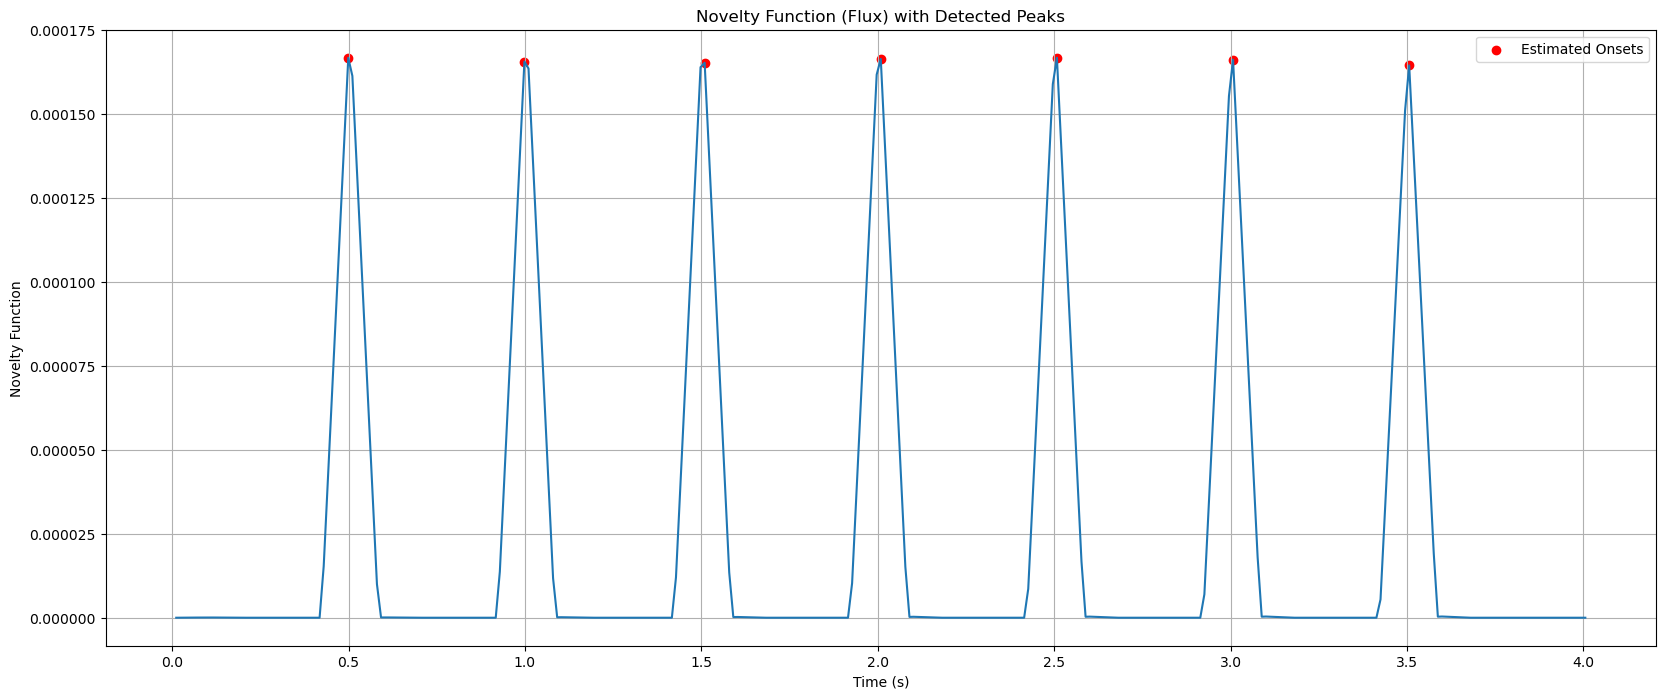

In [10]:
from utils.base import tickGen
from utils.visualize import visualizeNoveltyFunction
import matplotlib.pyplot as plt
from pyACA.ToolComputeHann import ToolComputeHann
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA import computeNoveltyFunction

# Configure parameters
iBlockLength = 1024
iHopLength = 512
novelty_func = 'Flux' # can be 'Hainsworth', 'Laroche'

# Generate ticking sound
f_s, wav = tickGen(bpm=120, sample_rate=44100)
afWindow = ToolComputeHann(iBlockLength)
# Preprocess audio (normalize & downmix)
x = ToolPreprocAudio(wav)
# Compute novelty function (using Flux algorithm for example)
[d, t, peaks] = computeNoveltyFunction(novelty_func, x, f_s, afWindow, iBlockLength, iHopLength)
visualizeNoveltyFunction(d, t, peaks)





Now, try apply onset detection on audio data from onset detection toy dataset:

/Users/lego/anaconda3/lib/python3.11/site-packages/pyACA/ToolReadAudio.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [f_s, x] = wavread(cAudioFilePath)


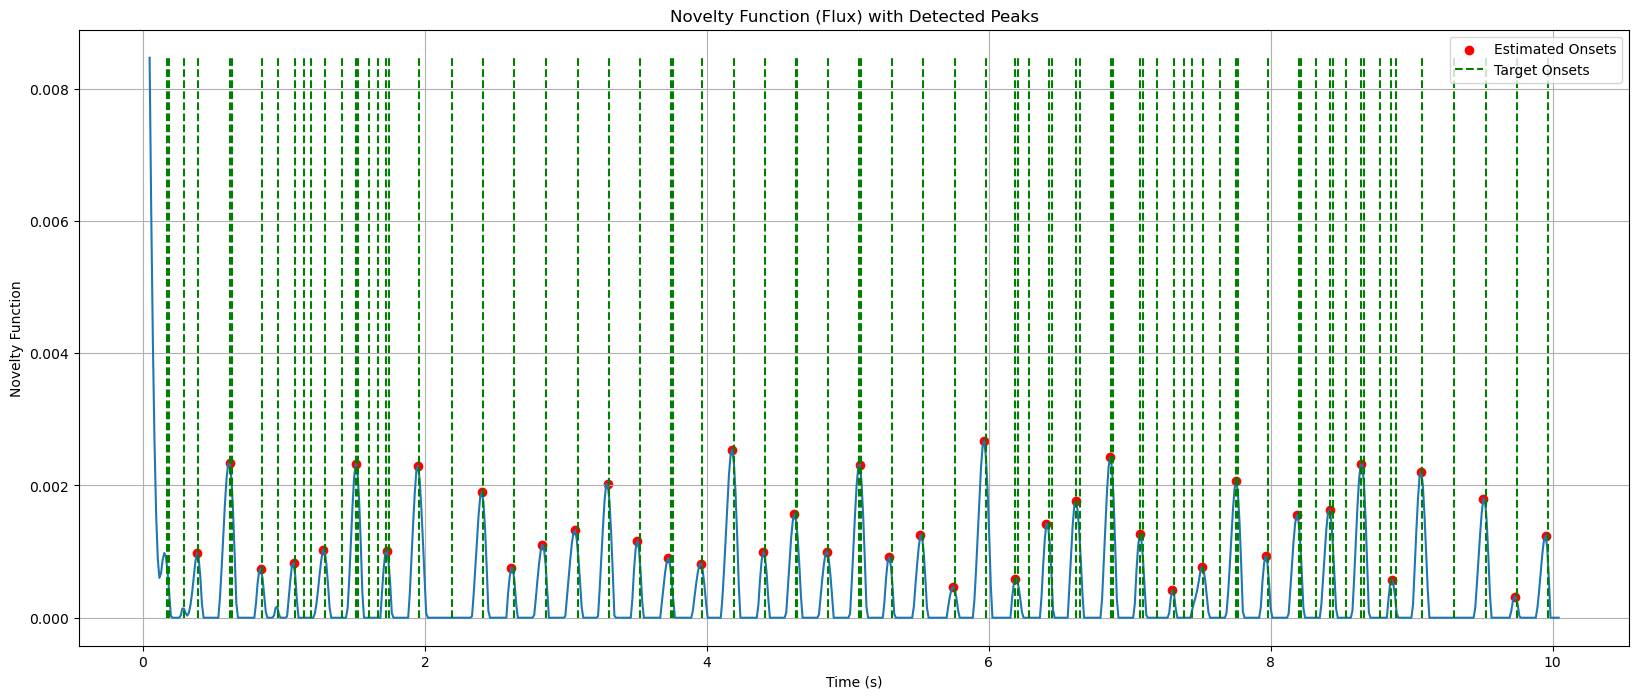

In [1]:
import numpy as np
from pyACA import ToolReadAudio
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA.ToolComputeHann import ToolComputeHann
from pyACA import computeNoveltyFunction
from utils.visualize import visualizeNoveltyFunction

f_s, wav = ToolReadAudio('asset/onset/Albums-I_Like_It2-01.wav')
# load from 13.1 second to 23.1 second
wav = wav[int(13.08 * f_s):int(23.08 * f_s)]

iBlockLength = 4096
iHopLength = 512
novelty_func = 'Laroche' # can be 'Flux', 'Hainsworth', 'Laroche'

# Generate ticking sound
afWindow = ToolComputeHann(iBlockLength)
# Preprocess audio (normalize & downmix)
x = ToolPreprocAudio(wav)
# Compute novelty function (using Flux algorithm for example)
[d, t, peaks] = computeNoveltyFunction(novelty_func, x, f_s, afWindow, iBlockLength, iHopLength)


# load target onsets
ref_onsets = np.loadtxt('asset/onset/Albums-I_Like_It2-01.txt', delimiter=',')
visualizeNoveltyFunction(d, t, peaks, target=ref_onsets)



# Evaluation
---
### Reference

Text book: [Sect. 9.3.3](https://ieeexplore.ieee.org/document/9966202/)

### Summary

We take esitmated onset times to compare with the reference onset times as given by the ground truth.
Predicted onsets within a tolerance interval around each ground truth interval are considered as correct, while others are incorrect. Typical tolerance intervals range from $\pm 25$ ms to $\pm 50$ ms.

### How it usually works:

#### 1. Precision, Recall, F-Measure



In [2]:
import utils.eval as eval
est_onset = t[peaks]
f_measure, precision, recall = eval.computeTemporalFmeasure(est_onset, ref_onsets)
print(f"F-Measure: {f_measure:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

F-Measure: 0.43, Precision: 1.00, Recall: 0.27


#### 2. Deviation statistics

Given $ \Delta t_o(j) = t_o(j) − \hat{t_o}(j) $
Some other metric could be:
1. Mean deviation: $$d_{mean} = \sum_{\forall j} \Delta t_o(j) $$
2. Standard deviation: $$\sqrt{\frac{1}{TP+FP} \sum_{\forall j} (t_o(j) - d_{mean})^2}$$
3. Max deviation: $$ max|\Delta t_o(j)|$$